### Look at how to run CCGP on confidence for behavioral model feature values
- Input data: 
  - Feature values from behavioral model as input data
  - Feature probabilities (softmaxed)
- Target (label), some metric of confidence: 
  - MaxValueBin, 
  - FeatureEntropyBin
- Some definition of condition: 
  - MaxFeatDim
  - MaxFeat
  - RuleDim
  - CurrentRule
- Assess CCGP using: within condition, across condition, overall 
- Additionally: Try this out with value encoded neurons, orthogonal encoding weights, with noise, 

Prediction: 
- ccgp is poor for when using values to decode. 

Conclusion:
- seems like a mixed bag based off setup

In [1]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import pandas as pd
import utils.behavioral_utils as behavioral_utils
import utils.information_utils as information_utils
import utils.visualization_utils as visualization_utils
import utils.glm_utils as glm_utils
from matplotlib import pyplot as plt
import utils.spike_utils as spike_utils
from constants.glm_constants import *
from constants.behavioral_constants import *

import seaborn as sns

from scipy.stats import ortho_group
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
import seaborn as sns
import scipy.stats


In [2]:
num_bins = 2

def get_sess_beh(row, beh_path):
    session = row.session_name
    behavior_path = beh_path.format(sess_name=session)
    beh = pd.read_csv(behavior_path)

    # filter trials 
    valid_beh = behavioral_utils.get_valid_trials(beh)
    feature_selections = behavioral_utils.get_selection_features(valid_beh)
    valid_beh = pd.merge(valid_beh, feature_selections, on="TrialNumber", how="inner")
    beh = behavioral_utils.get_feature_values_per_session(session, valid_beh)
    beh = behavioral_utils.get_relative_block_position(beh, 10)
    beh = behavioral_utils.get_max_feature_value(beh, num_bins)
    beh = behavioral_utils.calc_feature_probs(beh)
    beh = behavioral_utils.calc_feature_value_entropy(beh)
    beh = behavioral_utils.calc_confidence(beh, num_bins, quantize_bins=True)
    beh["ConfidenceLabel"] = beh.apply(lambda row: f"High {row.MaxFeat}" if row.ConfidenceBin == 1 else "Low", axis=1)
    beh["ConfidenceLabelDim"] = beh.apply(lambda row: f"High {FEATURE_TO_DIM[row.MaxFeat]}" if row.ConfidenceBin == 1 else "Low", axis=1)
    beh["session"] = session
    return beh

In [3]:
# Monkey S
SESSIONS_PATH = "/data/patrick_res/sessions/valid_sessions_rpe.pickle"
sessions = pd.read_pickle(SESSIONS_PATH)
beh_path = SESS_BEHAVIOR_PATH
res = pd.concat(sessions.apply(lambda x: get_sess_beh(x, beh_path), axis=1).values).reset_index()

In [4]:
res["RuleDim"] = res.CurrentRule.map(FEATURE_TO_DIM)

In [11]:
def train_model(frs, labels):
    x_train, x_test, y_train, y_test = train_test_split(frs, labels)
    model = LogisticRegression(penalty=None)
    # model = LogisticRegression()
    model = model.fit(x_train, y_train)
    train_score = model.score(x_train, y_train)
    test_score = model.score(x_test, y_test)
    return model, train_score, test_score

def evaluate_model(model, frs, labels):
    _, x_test, _, y_test = train_test_split(frs, labels)
    test_score = model.score(x_test, y_test)
    return test_score

def evaluate_ccgp(beh, x_columns, label_column, condition_column, num_samples=10):
    res = []
    for condition in beh[condition_column].unique():
        in_cond = beh[beh[condition_column] == condition]
        for _ in range(num_samples):
            condition_xs = in_cond[x_columns].values
            condition_labels = in_cond[label_column].values
            model, _, test_score = train_model(condition_xs, condition_labels)
            res.append({"type": "within cond", "score": test_score})

            overall_model, _, overall_test_score = train_model(beh[x_columns].values, beh[label_column].values)
            res.append({"type": "overall", "score": overall_test_score})

            other_conds = [c for c in beh[condition_column].unique() if c != condition]

            for other_cond in other_conds:
                cross_cond = beh[beh[condition_column] == other_cond]
                other_xs = cross_cond[x_columns].values
                other_labels = cross_cond[label_column].values
                other_test_score = evaluate_model(model, other_xs, other_labels)
                res.append({"type": "across cond", "score": other_test_score})
    return pd.DataFrame(res)

def custom_evaluate_ccgp(beh, x_columns, label_column, condition_column, conditions, num_samples=10):
    """
    condition_column: 
    conditions: either features or dimensions
    """
    res = []
    for cond in conditions:
        for _ in range(num_samples):
            sub_beh = beh[beh[condition_column].isin([f"High {cond}", "Low"])]
            sub_beh_balanced = behavioral_utils.balance_trials_by_condition(sub_beh, [condition_column])
            condition_xs = sub_beh_balanced[x_columns].values
            condition_labels = sub_beh_balanced[label_column].values
            model, _, test_score = train_model(condition_xs, condition_labels)
            res.append({"type": "within cond", "score": test_score})

            overall_model, _, overall_test_score = train_model(beh[x_columns].values, beh[label_column].values)
            res.append({"type": "overall", "score": overall_test_score})

            other_conds = [c for c in FEATURES if c != conditions]

            for other_cond in other_conds:
                sub_beh = beh[beh[condition_column].isin([f"High {other_cond}", "Low"])]
                sub_beh_balanced = behavioral_utils.balance_trials_by_condition(sub_beh, [condition_column])
                other_xs = sub_beh_balanced[x_columns].values
                other_labels = sub_beh_balanced[label_column].values
                other_test_score = evaluate_model(model, other_xs, other_labels)
                res.append({"type": "across cond", "score": other_test_score})
    return pd.DataFrame(res)

### Look at CCGP across a whole bunch of inputs, (Value vs Prob), labels (MaxValueBin, ConfidenceBin), conditions (Features vs. Dims)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

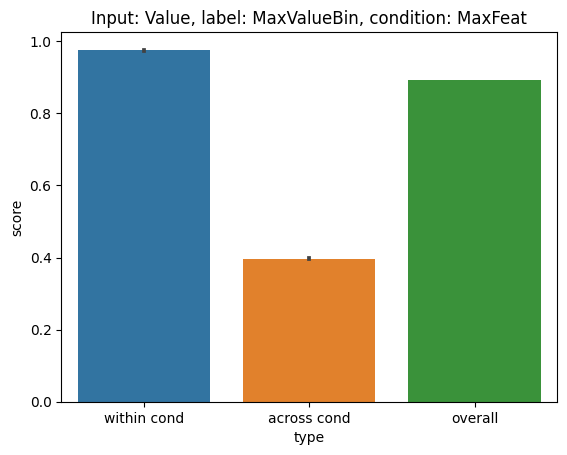

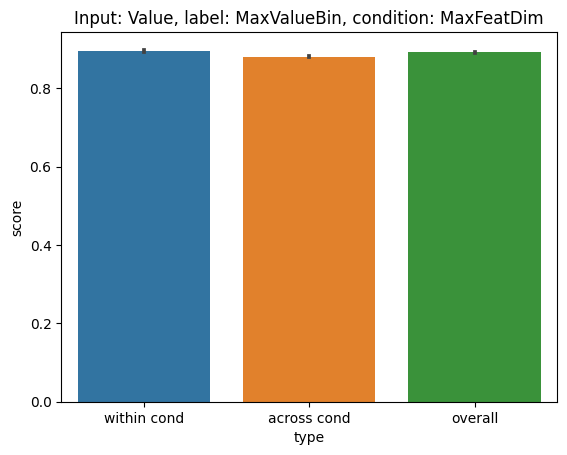

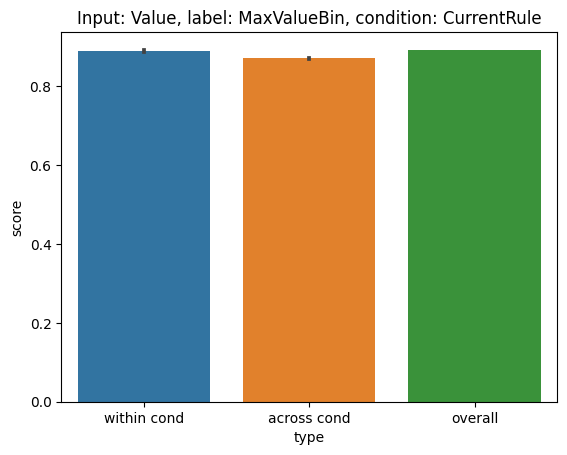

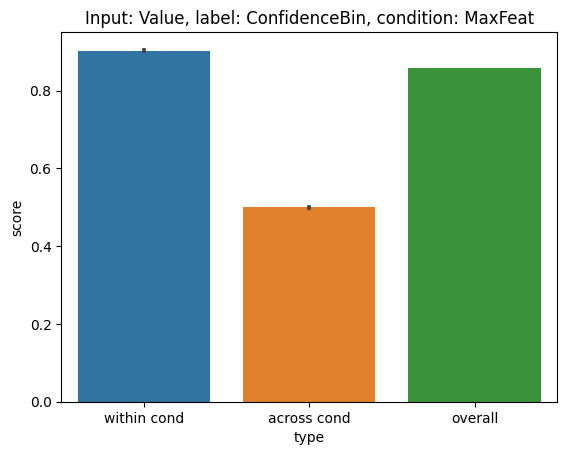

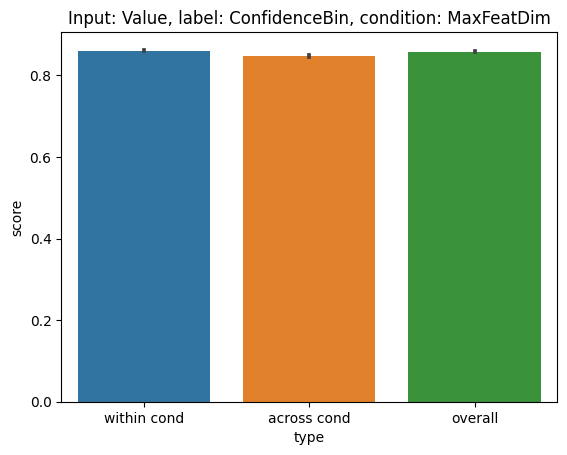

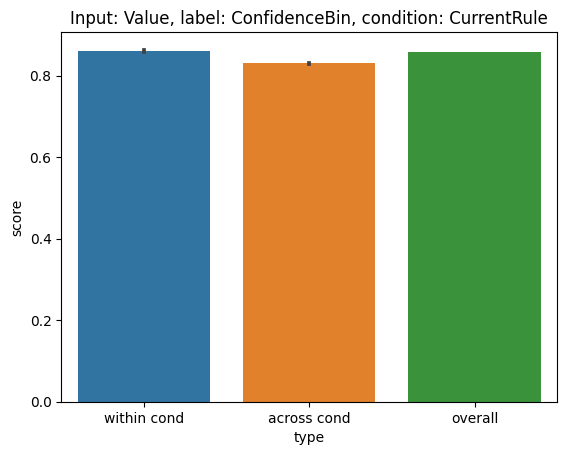

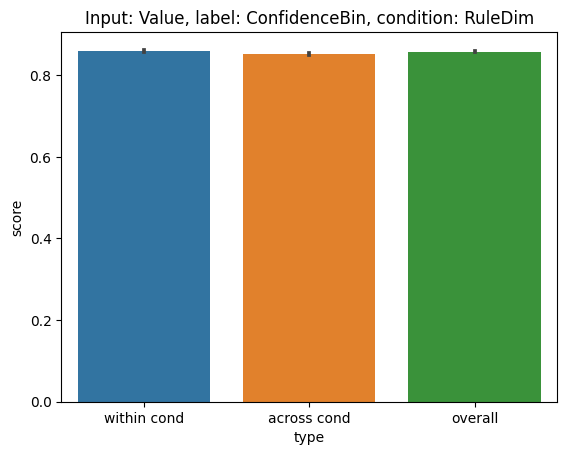

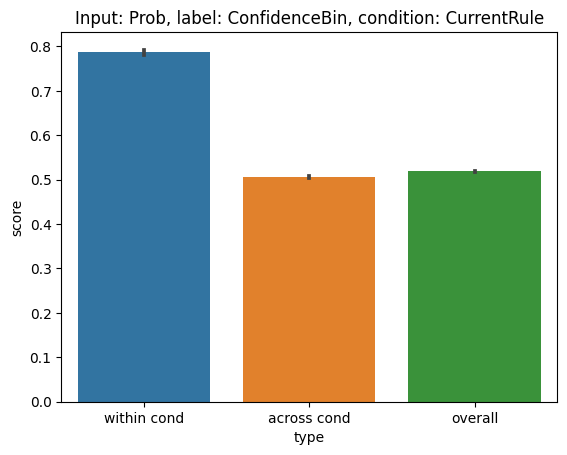

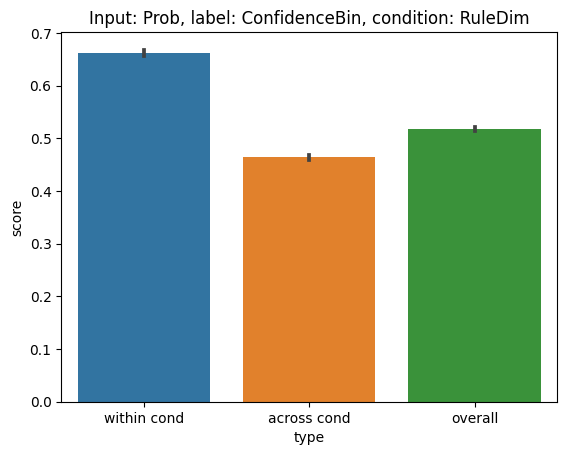

In [17]:
# sub_res = res[res.ConfidenceBin.isin([0, 2])]
configs = [
    ("Value", "MaxValueBin", "MaxFeat"),
    ("Value", "MaxValueBin", "MaxFeatDim"),
    ("Value", "MaxValueBin", "CurrentRule"),
    ("Value", "ConfidenceBin", "MaxFeat"),
    ("Value", "ConfidenceBin", "MaxFeatDim"),
    ("Value", "ConfidenceBin", "CurrentRule"),
    ("Value", "ConfidenceBin", "RuleDim"),
    ("Prob", "ConfidenceBin", "CurrentRule"),
    ("Prob", "ConfidenceBin", "RuleDim"),
]

for (input, label, condition) in configs:
    x_cols = [f"{feat}{input}" for feat in FEATURES]
    ccgp_res = evaluate_ccgp(res, x_cols, label, condition)

    fig, ax = plt.subplots()
    sns.barplot(ccgp_res, x="type", y="score", order=["within cond", "across cond", "overall"], ax=ax)
    ax.set_title(f"Input: {input}, label: {label}, condition: {condition}")

### Closest to neural decoding: 
Values as inputs, max feature dimensions as conditions, filter by attended to, balance by condition

Text(0.5, 1.0, 'Input: Value, label: ConfidenceBin, condition: MaxFeatDim')

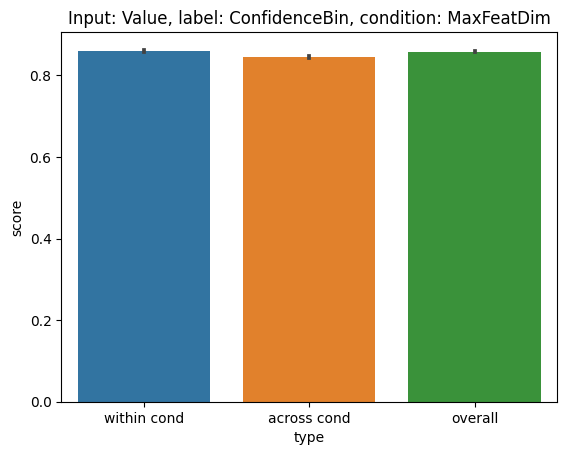

In [10]:
filt_res = behavioral_utils.filter_max_feat_chosen(res)
balanced_res = behavioral_utils.balance_trials_by_condition(filt_res, ["MaxFeatDim", "ConfidenceBin"])

input, label, condition = ("Value", "ConfidenceBin", "MaxFeatDim")

x_cols = [f"{feat}{input}" for feat in FEATURES]
ccgp_res = evaluate_ccgp(res, x_cols, label, condition)

fig, ax = plt.subplots()
sns.barplot(ccgp_res, x="type", y="score", order=["within cond", "across cond", "overall"], ax=ax)
ax.set_title(f"Input: {input}, label: {label}, condition: {condition}")

### Why are things generalizable when using values vs. probabilities??

<Axes: >

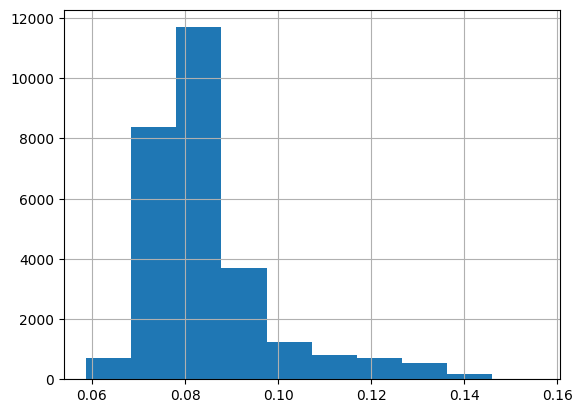

In [19]:
res["YELLOWProb"].hist()

<Axes: >

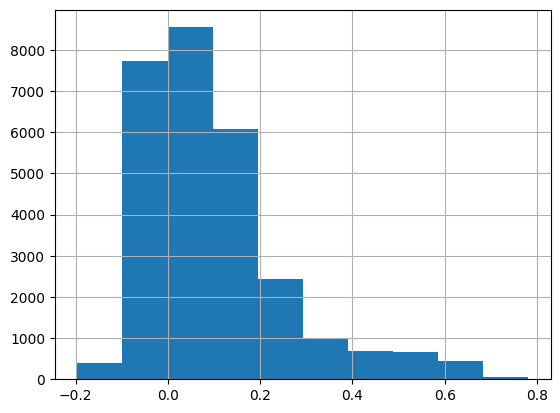

In [20]:
res["YELLOWValue"].hist()

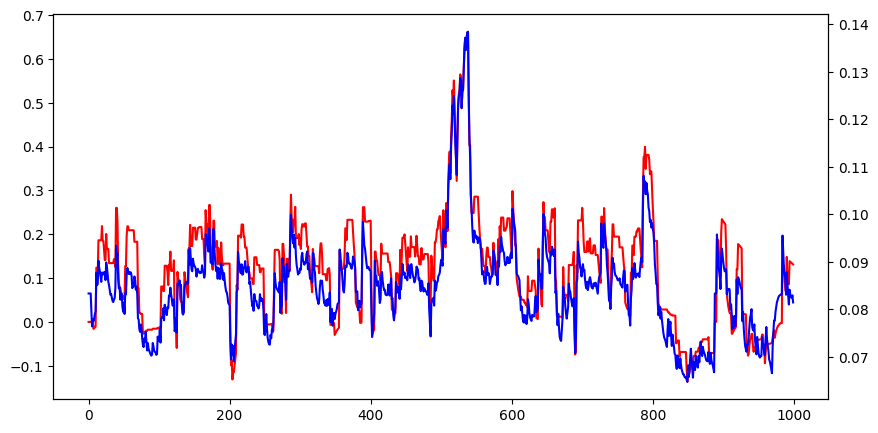

In [47]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(res["YELLOWValue"][:1000].values, color="r")
ax_prob = ax.twinx()
ax_prob.plot(res["YELLOWProb"][:1000].values, color="b")

### Plot values vs. probabilities of two random features (within and out of dim), only on trials where one is the rule or the other

<Axes: xlabel='SQUAREProb', ylabel='CIRCLEProb'>

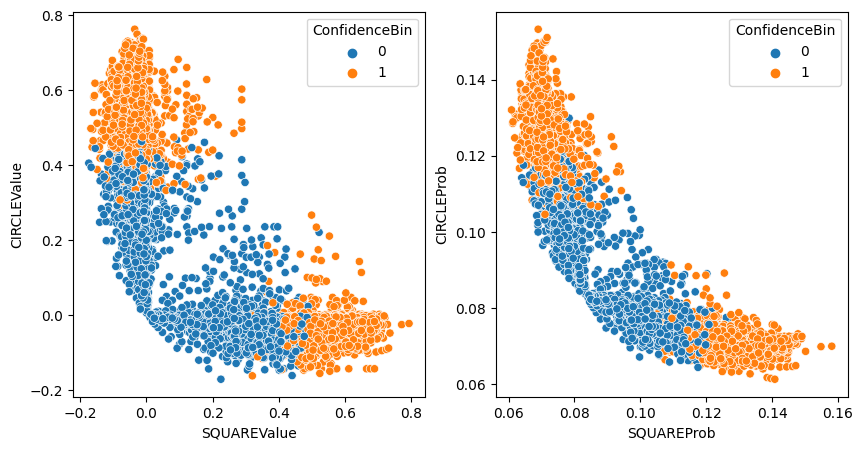

In [11]:
feat1 = "SQUARE"
feat2 = "CIRCLE"
sub_res = res[res.MaxFeat.isin([feat1, feat2])]
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
sns.scatterplot(sub_res, x=f"{feat1}Value", y=f"{feat2}Value", hue="ConfidenceBin", ax=axs[0])
sns.scatterplot(sub_res, x=f"{feat1}Prob", y=f"{feat2}Prob", hue="ConfidenceBin", ax=axs[1])


<Axes: xlabel='SQUAREProb', ylabel='CYANProb'>

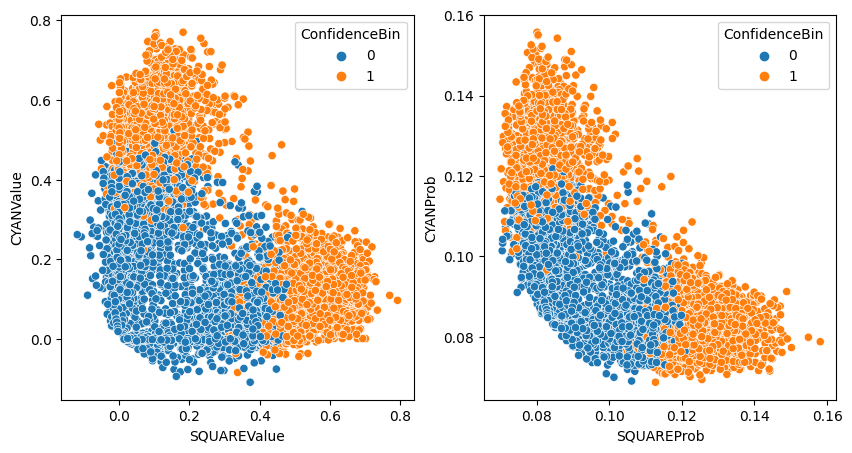

In [13]:
feat1 = "SQUARE"
feat2 = "CYAN"
sub_res = res[res.MaxFeat.isin([feat1, feat2])]
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
sns.scatterplot(sub_res, x=f"{feat1}Value", y=f"{feat2}Value", hue="ConfidenceBin", ax=axs[0])
sns.scatterplot(sub_res, x=f"{feat1}Prob", y=f"{feat2}Prob", hue="ConfidenceBin", ax=axs[1])


### What if we split up confidence into states: 
- low conf (below median)
- high conf with certain max feat

<Axes: xlabel='CYANProb', ylabel='SWIRLProb'>

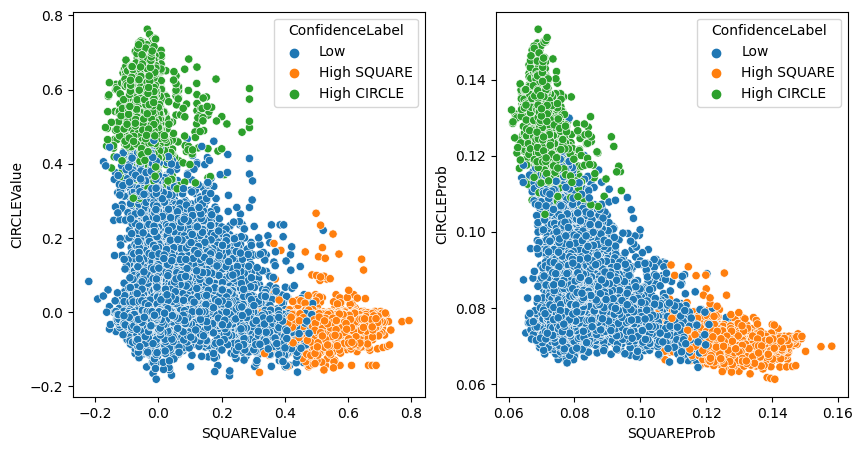

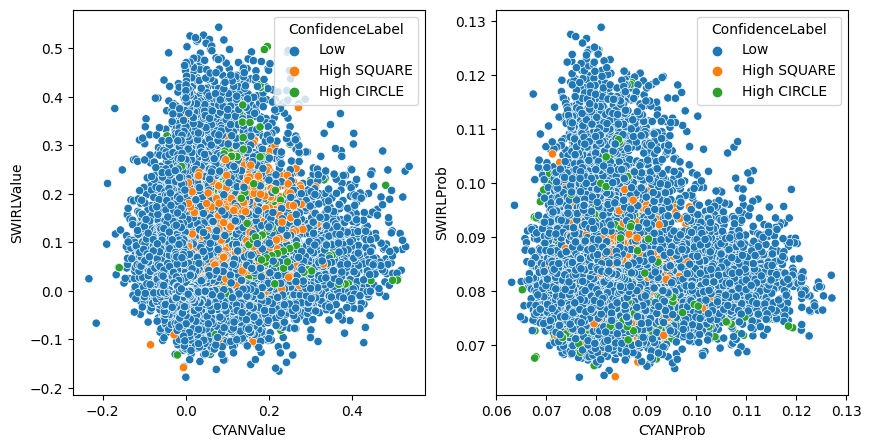

In [8]:
feat1 = "SQUARE"
feat2 = "CIRCLE"
sub_res = res[res.ConfidenceLabel.isin(["Low", f"High {feat1}", f"High {feat2}"])]
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
sns.scatterplot(sub_res, x=f"{feat1}Value", y=f"{feat2}Value", hue="ConfidenceLabel", ax=axs[0])
sns.scatterplot(sub_res, x=f"{feat1}Prob", y=f"{feat2}Prob", hue="ConfidenceLabel", ax=axs[1])

notfeat1 = "CYAN"
notfeat2 = "SWIRL"
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
sns.scatterplot(sub_res, x=f"{notfeat1}Value", y=f"{notfeat2}Value", hue="ConfidenceLabel", ax=axs[0])
sns.scatterplot(sub_res, x=f"{notfeat1}Prob", y=f"{notfeat2}Prob", hue="ConfidenceLabel", ax=axs[1])


### Re-run CCGP with these new confidence labels

Text(0.5, 1.0, 'Input: Value, label: ConfidenceBin, by dimensions')

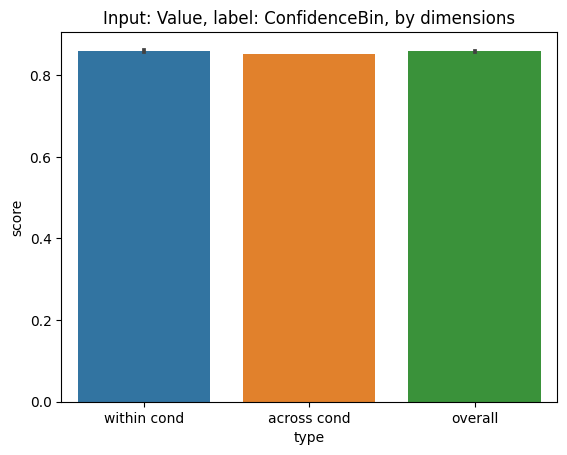

In [25]:
input, label, condition_col, conditions = "Value", "ConfidenceBin", "ConfidenceLabelDim", FEATURE_DIMS
x_cols = [f"{feat}{input}" for feat in FEATURES]
ccgp_res = custom_evaluate_ccgp(res, x_cols, label, condition_col, conditions, num_samples=10)
fig, ax = plt.subplots()
sns.barplot(ccgp_res, x="type", y="score", order=["within cond", "across cond", "overall"], ax=ax)
ax.set_title(f"Input: {input}, label: {label}, by dimensions")

Text(0.5, 1.0, 'Input: Value, label: ConfidenceBin, by features')

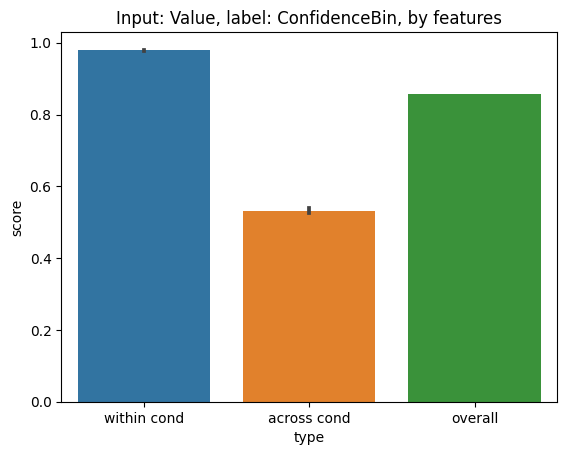

In [26]:
input, label, condition_col, conditions = "Value", "ConfidenceBin", "ConfidenceLabel", FEATURES
x_cols = [f"{feat}{input}" for feat in FEATURES]
ccgp_res = custom_evaluate_ccgp(res, x_cols, label, condition_col, conditions, num_samples=10)
fig, ax = plt.subplots()
sns.barplot(ccgp_res, x="type", y="score", order=["within cond", "across cond", "overall"], ax=ax)
ax.set_title(f"Input: {input}, label: {label}, by features")

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Text(0.5, 1.0, 'Input: Prob, label: ConfidenceBin, by dimensions')

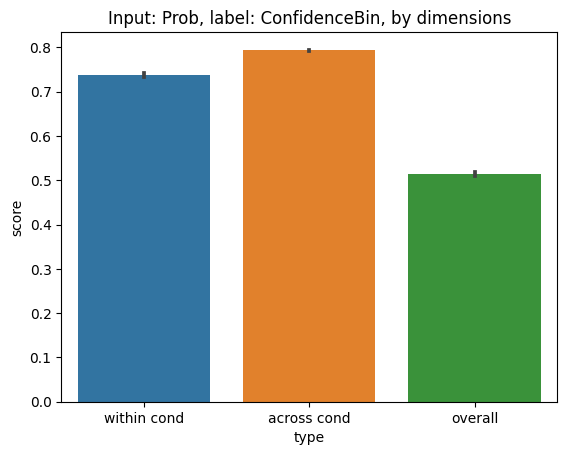

In [27]:
input, label, condition_col, conditions = "Prob", "ConfidenceBin", "ConfidenceLabelDim", FEATURE_DIMS
x_cols = [f"{feat}{input}" for feat in FEATURES]
ccgp_res = custom_evaluate_ccgp(res, x_cols, label, condition_col, conditions, num_samples=10)
fig, ax = plt.subplots()
sns.barplot(ccgp_res, x="type", y="score", order=["within cond", "across cond", "overall"], ax=ax)
ax.set_title(f"Input: {input}, label: {label}, by dimensions")

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Text(0.5, 1.0, 'Input: Prob, label: ConfidenceBin, by features')

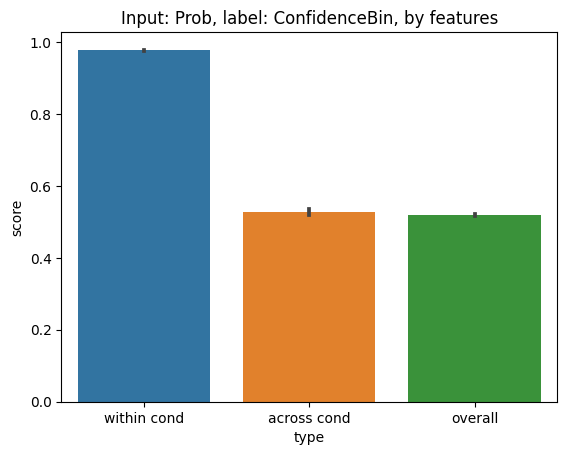

In [10]:
input, label, condition_col, conditions = "Prob", "ConfidenceBin", "ConfidenceLabel", FEATURES
x_cols = [f"{feat}{input}" for feat in FEATURES]
ccgp_res = custom_evaluate_ccgp(res, x_cols, label, condition_col, conditions, num_samples=10)
fig, ax = plt.subplots()
sns.barplot(ccgp_res, x="type", y="score", order=["within cond", "across cond", "overall"], ax=ax)
ax.set_title(f"Input: {input}, label: {label}, by features")

### Effect of injecting noise 

In [25]:
noise_stds = np.arange(0, 0.5, 0.1)
rng = np.random.default_rng()
input, label, condition_col, conditions = "Value", "ConfidenceBin", "ConfidenceLabel", FEATURES
noisy_res = []
for noise_std in noise_stds:
    noise_mat = rng.normal(0, scale=noise_std, size=(len(res), 12))
    x_cols = [f"{feat}{input}" for feat in FEATURES]
    x_cols_noisy = [f"{feat}{input}Noisy" for feat in FEATURES]
    noisy_vals = res[x_cols].values + noise_mat
    noise_df = pd.DataFrame(data=noisy_vals, columns=x_cols_noisy)
    res_w_noisy = pd.concat((res, noise_df), axis=1)
    ccgp_res = custom_evaluate_ccgp(res_w_noisy, x_cols_noisy, label, condition_col, conditions, num_samples=10)
    ccgp_res["Noise Level"] = noise_std
    noisy_res.append(ccgp_res)
noisy_res = pd.concat(noisy_res)

<Axes: xlabel='Noise Level', ylabel='score'>

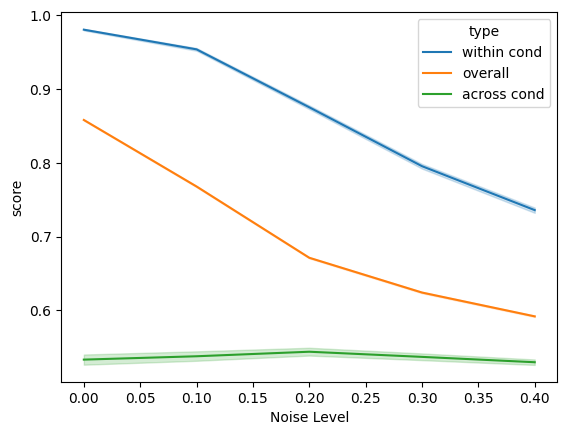

In [27]:
sns.lineplot(noisy_res, x="Noise Level", y="score", hue="type")

In [ ]:
noise_stds = np.arange(0, 0.5, 0.1)
rng = np.random.default_rng()
input, label, condition_col, conditions = "Prob", "ConfidenceBin", "ConfidenceLabel", FEATURES
noisy_res = []
for noise_std in noise_stds:
    noise_mat = rng.normal(0, scale=noise_std, size=(len(res), 12))
    x_cols = [f"{feat}{input}" for feat in FEATURES]
    x_cols_noisy = [f"{feat}{input}Noisy" for feat in FEATURES]
    noisy_vals = res[x_cols].values + noise_mat
    noise_df = pd.DataFrame(data=noisy_vals, columns=x_cols_noisy)
    res_w_noisy = pd.concat((res, noise_df), axis=1)
    ccgp_res = custom_evaluate_ccgp(res_w_noisy, x_cols_noisy, label, condition_col, conditions, num_samples=10)
    ccgp_res["Noise Level"] = noise_std
    noisy_res.append(ccgp_res)
noisy_res = pd.concat(noisy_res)

<Axes: xlabel='Noise Level', ylabel='score'>

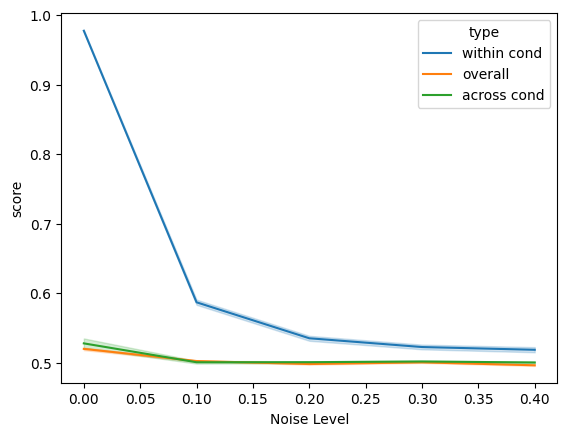

In [29]:
sns.lineplot(noisy_res, x="Noise Level", y="score", hue="type")

### What if projecting to 100 units, with random unit norm betas?

In [12]:
def get_random_betas(num_units, num_vars, rng):
    """
    Returns reps that will be shape [num_units, num_vars]
    """
    randoms = rng.normal(0, 1, size=(num_units, num_vars))
    normed = randoms / np.linalg.norm(randoms, axis=0)
    return normed

def get_random_values(num_trials, num_vars, rng):
    """
    Returns values that will be of shape [num_vars, num_trials]
    """
    return rng.uniform(0, 1, size=(num_vars, num_trials))

def get_random_values_gaussian(num_trials, num_vars, rng):
    return rng.normal(0, 1, size=(num_vars, num_trials))

def simulate_neural_activity(betas, vars, rng, noise_std):
    noise = rng.normal(0, noise_std, size=(betas.shape[0], vars.shape[1]))
    return betas @ vars + noise

In [11]:
num_units = 100
num_vars = 12
num_samples = 10
noise_stds = np.arange(0, 0.5, 0.1)
label, condition_col, conditions = "ConfidenceBin", "ConfidenceLabel", FEATURES
rng = np.random.default_rng()
val_cols = [f"{feat}Prob" for feat in FEATURES]
vars = res[val_cols].values.T
frs_res = []
for noise_std in noise_stds:
    for i in range(num_samples):
        betas = get_random_betas(num_units, num_vars, rng)
        frs = simulate_neural_activity(betas, vars, rng, noise_std)
        frs_df = pd.DataFrame(frs.T, columns=list(range(100)))
        res_frs = pd.concat((res, frs_df), axis=1)
        ccgp_res = custom_evaluate_ccgp(res_frs, list(range(100)), label, condition_col, conditions, num_samples=1)
        ccgp_res["Noise Level"] = noise_std
        frs_res.append(ccgp_res)
frs_res = pd.concat(frs_res)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Text(0.5, 1.0, 'CCGP from simulated firing rates (from probs), 100 neurons, random betas')

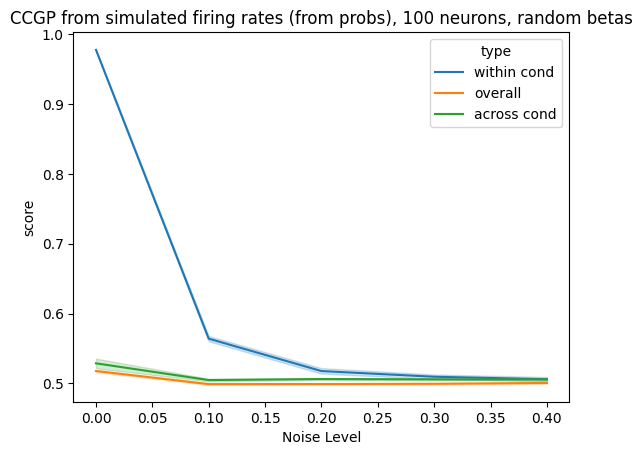

In [12]:
fig, ax = plt.subplots()
sns.lineplot(frs_res, x="Noise Level", y="score", hue="type", ax=ax)
ax.set_title("CCGP from simulated firing rates (from probs), 100 neurons, random betas")

In [20]:
res_frs

,level_0,index,TrialNumber,BlockNumber,TrialAfterRuleChange,TaskInterrupt,ConditionNumber,Response,ItemChosen,TrialType,...,90,91,92,93,94,95,96,97,98,99
0,0,0,49,2,0,NaN,2258,Incorrect,2.0,11,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,1,1,50,2,1,NaN,1881,Incorrect,2.0,11,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,2,2,51,2,2,NaN,2206,Incorrect,3.0,11,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,3,3,52,2,3,NaN,2005,Correct,0.0,11,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,4,4,53,2,4,NaN,1834,Correct,0.0,11,...,0.067861,0.074730,0.032373,0.024551,0.047313,0.062295,0.053380,0.051311,0.053203,0.048988
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28008,853,853,876,26,13,NaN,2654,Correct,0.0,4,...,0.108970,0.218939,0.086325,0.103015,0.120917,0.150355,0.112587,0.140282,0.124371,0.163697
28009,854,854,877,26,14,NaN,2557,Correct,0.0,4,...,0.112290,0.225568,0.089184,0.105341,0.121950,0.151827,0.116475,0.141402,0.126546,0.166232
28010,855,855,878,26,15,NaN,2696,Correct,0.0,4,...,0.111789,0.228096,0.088891,0.109062,0.125153,0.156299,0.113142,0.143264,0.129100,0.168713
28011,856,856,879,26,16,NaN,2567,Correct,0.0,4,...,0.112639,0.232372,0.094022,0.116122,0.127353,0.156518,0.114624,0.146181,0.129581,0.175746


### Generate simulated firing rates, to use in decoding
- Go through each session, look at number of units in session. 
- For that session, grab feature values, random projection beta vectors, and generate N x K (units x trials) worth of firing rates


In [17]:
positions = spike_utils.get_unit_positions(sessions).reset_index(drop=True)

In [18]:
positions

,Channel,Unit,SpikeTimesFile,UnitID,electrode_id,x,y,z,distance,in_brain,...,structure_level1,structure_level2,structure_level3,structure_level4,structure_level5,structure_level6,structure_potential,session,PseudoUnitID,manual_structure
0,100,1,/data/rawdata/sub-SA/sess-20180709/spikes/sub-...,0,100,13.535342,-55.049086,19.90947,27.5,True,...,telencephalon (tel),lateral_and_ventral_pallium (LVPal),lateral_pallium (LPal),claustrum (Cl),claustrum (Cl),claustrum (Cl),[],20180709,2018070900,Claustrum
1,108,1,/data/rawdata/sub-SA/sess-20180709/spikes/sub-...,1,108,13.699304,-54.08206,21.82937,28.75,True,...,telencephalon (tel),lateral_and_ventral_pallium (LVPal),lateral_pallium (LPal),claustrum (Cl),claustrum (Cl),claustrum (Cl),[],20180709,2018070901,Claustrum
2,109,1,/data/rawdata/sub-SA/sess-20180709/spikes/sub-...,2,109,15.204069,-54.488859,21.577754,27.5,True,...,telencephalon (tel),lateral_and_ventral_pallium (LVPal),lateral_pallium (LPal),claustrum (Cl),claustrum (Cl),claustrum (Cl),[],20180709,2018070902,Claustrum
3,10a,1,/data/rawdata/sub-SA/sess-20180709/spikes/sub-...,3,10a,0.789428,-75.75489,38.106774,9,True,...,Frontal_Lobe (Frontal),lateral_prefrontal_cortex (lat_PFC),dorsolateral_prefrontal_cortex (dlPFC),area_8B (area_8B),area_8B (area_8B),medial_area_8B (area_8Bm),dlPFC,20180709,2018070903,Prefrontal Cortex
4,10a,2,/data/rawdata/sub-SA/sess-20180709/spikes/sub-...,4,10a,0.789428,-75.75489,38.106774,9,True,...,Frontal_Lobe (Frontal),lateral_prefrontal_cortex (lat_PFC),dorsolateral_prefrontal_cortex (dlPFC),area_8B (area_8B),area_8B (area_8B),medial_area_8B (area_8Bm),dlPFC,20180709,2018070904,Prefrontal Cortex
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
751,90,1,/data/rawdata/sub-SA/sess-20180910/spikes/sub-...,25,90,10.452756,-52.703145,19.318001,31.125,True,...,telencephalon (tel),amygdala (Amy),pallial_amygdala (pAmy),lateropallial_amygdala (lpAmy),lateral_amygdaloid_nucleus (La),lateral_dorsal_amygdaloid_nucleus (LaD),Hippocampal,20180910,2018091025,Amygdala
752,92,1,/data/rawdata/sub-SA/sess-20180910/spikes/sub-...,26,92,13.520363,-51.91999,19.341959,30.625,True,...,telencephalon (tel),basal_ganglia (BG),striatum (Str),dorsal_striatum (DStr),caudate (Cd),caudate_tail (CdT),Hippocampal,20180910,2018091026,Basal Ganglia
753,95,1,/data/rawdata/sub-SA/sess-20180910/spikes/sub-...,27,95,5.433664,-68.902483,15.922112,16,True,...,telencephalon (tel),basal_ganglia (BG),striatum (Str),dorsal_striatum (DStr),caudate (Cd),caudate_head (CdH),[],20180910,2018091027,Basal Ganglia
754,99,1,/data/rawdata/sub-SA/sess-20180910/spikes/sub-...,28,99,12.140106,-51.630938,21.155323,31.75,True,...,telencephalon (tel),amygdala (Amy),pallial_amygdala (pAmy),lateropallial_amygdala (lpAmy),lateral_amygdaloid_nucleus (La),lateral_dorsal_amygdaloid_nucleus (LaD),Hippocampal,20180910,2018091028,Amygdala


In [20]:
num_units = 756
num_vals = 12
rng = np.random.default_rng()
betas = get_random_betas(num_units, num_vals, rng)
pos_w_betas = pd.concat((positions, pd.DataFrame(betas)), axis=1)


In [ ]:
pos_w_betas

In [27]:
def gen_frs_for_session(row, noise):
    session = row.session_name
    beh = res[res.session == session]
    val_cols = [f"{feat}Value" for feat in FEATURES]
    vals = beh[val_cols].T
    pos = pos_w_betas[pos_w_betas.session == session]
    betas = pos[list(range(num_vals))].values
    frs = simulate_neural_activity(betas, vals, rng, noise)
    frs_df = pd.DataFrame(frs.T)
    frs_df["TrialNumber"] = beh["TrialNumber"]
    melted = frs_df.melt(id_vars=["TrialNumber"], value_vars=list(range(frs.shape[0])), var_name="UnitID", value_name="FiringRate")
    melted["TimeBins"] = 0.0
    melted.to_pickle(f"/data/patrick_res/firing_rates/{session}_firing_rates_simulated_noise_{noise:.1f}.pickle")


noises = np.arange(0, 0.5, 0.1)
for noise in noises: 
    sessions.apply(lambda row: gen_frs_for_session(row, noise), axis=1)